In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

# Individual Project
## Deliverable 1: Project Proposal
### 1. What is your issue of interest (provide sufficient background information)?
    - auth.log for failed/successful logins as well as authentication processes.
    - var/log/auth.log on Ubuntu and Debian systems
    - contain any information relating to user authorization mechanism (sudo commands)
    - can be used defensively to determine if someone is trying to authenticate who doesn't have permission
    - can be used offensively to figure out who has authorization to the system and their most used avenue of access
    - logs remote logins

### 2. Why is this issue important to you and/or to others?
    - As a network analyst, one of my tasks is to analyze network traffic in order to determine what is happening in 
    the network. We track access vectors and types of traffic as well as parsing through authentication logs and 
    network connections. Surprisingly, my office does not have a data scientist. As such, we waste a lot of time 
    copying and pasting data into spreadsheets instead of using data cleansing, visualization, descriptive statistics, 
    or any other form of analysis that could be vastly helpful. Performing analysis on this data in particular will 
    help me recognize malicious traffic in networks as well as understand what access vectors are taken advantage of. 
    It will also help to identify different types of devices in networks and what they are used for.

### 3. What questions do you have in mind and would like to answer?
    - What IPs try to authenticate?
    - What services are used to authenticate?
    - What IP has the most failed login attempts?
    - what type authentication is the one that fails the most?
    - What IP is trying to be authenticated to?
    - are there any failed/successful remote logins
    - were there any privelege escalation attempts?
        - what commands were run

### 4. Where do you get the data to help answer your questions?
    - http://www.secrepo.com/auth.log/auth.log.gz

### 5. What will be your unit of analysis (for example, patient, organization, or country)? Roughly how many units do you expect to analyze?
    - This auth.log file is pulled from one device with the IP 172.31.27.153. There are approximately 86k lines in the file 
    (might break it down into smaller chunks)

### 6. What variables/measures do you plan to use in your analysis?
    - Data/time
    - Service
    - IP
    - Description
    - will add a username variable based off of descriptions containing usernames

### 7. What kinds of techniques do you you plan to use (for example, summary statistics, scatter plot, bar chart, chi-squared test)?
    - scatter plot - matching date to failed attempts,
    - bar chart - number of logins attempts per user (failure vs success)
    - anything that can show me number of occurances (ie. per username/ip)
    - common generated logs vs abnormal ones
    - I'm sure some kind of statistics once we learn a little more about it

### Read data in fixed width format and clean
- Columns don't match intended data at first
- More cleaning combines Month/Date/Time into one groupe DateTime
- Drop redundant columns
- Remove extra characters, mostly punctuation, from IP and Service columns

In [3]:
# reads the auth.log file into a dataframe. Is a fixed width format file
df = pd.read_fwf("auth.log", names=["DateTime", "Month", "Date", "Time", "IP", "Service", "Description"])

In [4]:
# shows first 5 lines of the file
df.head()

,DateTime,Month,Date,Time,IP,Service,Description
0,Nov,30,06:39:00,ip-172-31-27-153,CRON[21882]:,pam_unix(cron:session): session closed for use...,NaN
1,Nov,30,06:47:01,ip-172-31-27-153,CRON[22087]:,pam_unix(cron:session): session opened for use...,NaN
2,Nov,30,06:47:03,ip-172-31-27-153,CRON[22087]:,pam_unix(cron:session): session closed for use...,NaN
3,Nov,30,07:07:14,ip-172-31-27-153,sshd[22116]:,Connection closed by 122.225.103.87 [preauth],NaN
4,Nov,30,07:07:35,ip-172-31-27-153,sshd[22118]:,Connection closed by 122.225.103.87 [preauth],NaN


In [5]:
# converts all data to strings
df = df.astype(str)

- since it is a fixed width format file, the date/time was split into 3 separate columns. I wanted them all in one column so I added the three together and deleted the old ones

In [6]:
# concatenates the data in DateTime, Month, and Date into one column (overwrites DateTime Column)
df["DateTime"] = df["DateTime"] +" "+ df["Month"] + " " + df["Date"]
df.head()

,DateTime,Month,Date,Time,IP,Service,Description
0,Nov 30 06:39:00,30,06:39:00,ip-172-31-27-153,CRON[21882]:,pam_unix(cron:session): session closed for use...,nan
1,Nov 30 06:47:01,30,06:47:01,ip-172-31-27-153,CRON[22087]:,pam_unix(cron:session): session opened for use...,nan
2,Nov 30 06:47:03,30,06:47:03,ip-172-31-27-153,CRON[22087]:,pam_unix(cron:session): session closed for use...,nan
3,Nov 30 07:07:14,30,07:07:14,ip-172-31-27-153,sshd[22116]:,Connection closed by 122.225.103.87 [preauth],nan
4,Nov 30 07:07:35,30,07:07:35,ip-172-31-27-153,sshd[22118]:,Connection closed by 122.225.103.87 [preauth],nan


In [7]:
# deletes Month column
df.drop('Month', inplace=True, axis=1)

In [8]:
# deletes Date column 
df.drop('Date', inplace=True, axis=1)

In [9]:
df.head()

,DateTime,Time,IP,Service,Description
0,Nov 30 06:39:00,ip-172-31-27-153,CRON[21882]:,pam_unix(cron:session): session closed for use...,nan
1,Nov 30 06:47:01,ip-172-31-27-153,CRON[22087]:,pam_unix(cron:session): session opened for use...,nan
2,Nov 30 06:47:03,ip-172-31-27-153,CRON[22087]:,pam_unix(cron:session): session closed for use...,nan
3,Nov 30 07:07:14,ip-172-31-27-153,sshd[22116]:,Connection closed by 122.225.103.87 [preauth],nan
4,Nov 30 07:07:35,ip-172-31-27-153,sshd[22118]:,Connection closed by 122.225.103.87 [preauth],nan


In [10]:
# Renames the columns and adds a Connecting IP column to fill later
df.columns = ['DateTime', 'IP', 'Service', 'Description', 'Connecting IP']
df.head()

,DateTime,IP,Service,Description,Connecting IP
0,Nov 30 06:39:00,ip-172-31-27-153,CRON[21882]:,pam_unix(cron:session): session closed for use...,nan
1,Nov 30 06:47:01,ip-172-31-27-153,CRON[22087]:,pam_unix(cron:session): session opened for use...,nan
2,Nov 30 06:47:03,ip-172-31-27-153,CRON[22087]:,pam_unix(cron:session): session closed for use...,nan
3,Nov 30 07:07:14,ip-172-31-27-153,sshd[22116]:,Connection closed by 122.225.103.87 [preauth],nan
4,Nov 30 07:07:35,ip-172-31-27-153,sshd[22118]:,Connection closed by 122.225.103.87 [preauth],nan


In [11]:
# Remove leading ip string from IP column (works here because the IP is from the singular host device)
df["IP"]= df["IP"].replace("ip-172-31-27-153", "172.31.27.153")

In [12]:
# Remove string in brackets from Service column 
df["Service"] = df["Service"].str.replace('[\[^0-9\]:]', '', regex=True)

In [13]:
# shows number of rows and columns
df.shape

(86839, 5)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86839 entries, 0 to 86838
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   DateTime       86839 non-null  object
 1   IP             86839 non-null  object
 2   Service        86839 non-null  object
 3   Description    86839 non-null  object
 4   Connecting IP  86839 non-null  object
dtypes: object(5)
memory usage: 3.3+ MB


In [15]:
df.describe()

,DateTime,IP,Service,Description,Connecting IP
count,86839,86839,86839,86839,86839
unique,54811,1,11,10633,1
top,Dec 29 18:18:32,172.31.27.153,sshd,Received disconnect from 61.197.203.243: 11: B...,nan
freq,18,86839,83638,8996,86839


In [16]:
df.sample(5)

,DateTime,IP,Service,Description,Connecting IP
54131,Dec 14 03:39:21,172.31.27.153,sshd,reverse mapping checking getaddrinfo for stati...,nan
4232,Dec 2 04:14:06,172.31.27.153,sshd,Received disconnect from 173.192.158.3: 11: By...,nan
79151,Dec 28 04:30:42,172.31.27.153,sshd,input_userauth_request: invalid user dreamer [...,nan
12983,Dec 2 14:26:51,172.31.27.153,sshd,Received disconnect from 218.25.17.234: 11: By...,nan
55658,Dec 17 06:25:36,172.31.27.153,sshd,reverse mapping checking getaddrinfo for 177.4...,nan


### Main useful data is in the Description column
- IPs attempting to connect added to Connecting IP column
- Analysis on connecting IPs 
    - unique IPs
    - how many times one IP attempts to connect
- Visualization for conencting IPs and services
- Focus on invalid logins
    - number of occurances
    - IP and count per IP
    - isolate username from description

In [17]:
# If Description column contains the regex pattern for IP addresses, create neew column with the IP
df["Connecting IP"] = df["Description"].str.extract(r'(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})')

In [18]:
df.head()

,DateTime,IP,Service,Description,Connecting IP
0,Nov 30 06:39:00,172.31.27.153,CRON,pam_unix(cron:session): session closed for use...,NaN
1,Nov 30 06:47:01,172.31.27.153,CRON,pam_unix(cron:session): session opened for use...,NaN
2,Nov 30 06:47:03,172.31.27.153,CRON,pam_unix(cron:session): session closed for use...,NaN
3,Nov 30 07:07:14,172.31.27.153,sshd,Connection closed by 122.225.103.87 [preauth],122.225.103.87
4,Nov 30 07:07:35,172.31.27.153,sshd,Connection closed by 122.225.103.87 [preauth],122.225.103.87


In [19]:
# Creates new dataframe of unique IPs from Connecting IP column
uniqueIP = pd.DataFrame(df['Connecting IP'].unique().tolist())
uniqueIP.head(5)

,0
0,NaN
1,122.225.103.87
2,187.12.249.74
3,196.200.90.236
4,1.93.26.70


In [20]:
# Since I only want the first 4 charachters of each service, going to slice out the extras. 
df['Service'] = df['Service'].str.slice(stop=4)

In [21]:
# Create list of unique services. Not sure where the extra letters came from. 
# Doesn't do this in Colab and they aren't in the data file
unique_service = pd.DataFrame(df['Service'].unique().tolist())
unique_service

,0
0,CRON
1,sshd


In [22]:
# Creates new dataframe with a column that counts the total number of occurances of that IP
connecting_IP = pd.DataFrame(df['Connecting IP'].value_counts().reset_index().values, columns=["IP", "Count"])
connecting_IP.head()

,IP,Count
0,61.197.203.243,11261
1,220.99.93.50,10752
2,218.25.17.234,5616
3,188.87.35.25,2013
4,67.205.20.23,1804


In [23]:
# Shows number of unique IPs
df['Connecting IP'].nunique()

1906

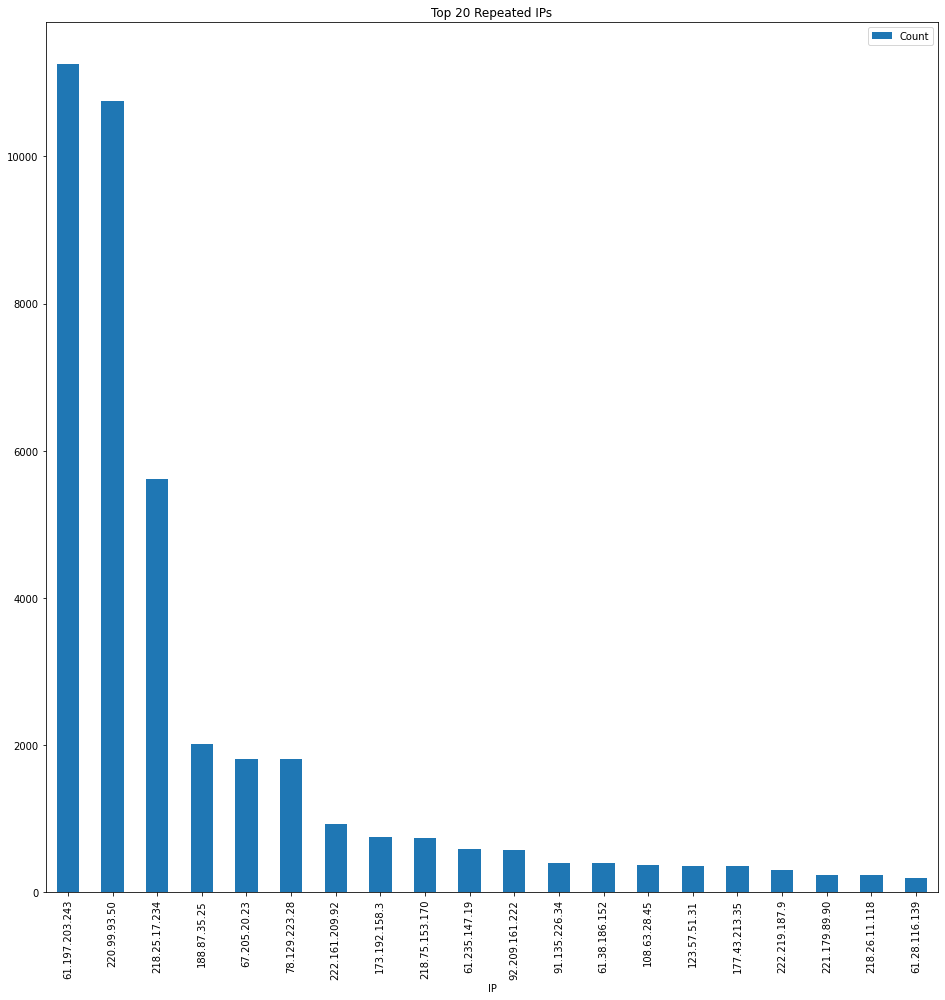

In [24]:
# creates bar chart of the top 20 repeated IPs
connecting_IP.iloc[0:20].plot(kind='bar', title='Top 20 Repeated IPs', x='IP', y='Count', figsize=(16,16))  
plt.show()

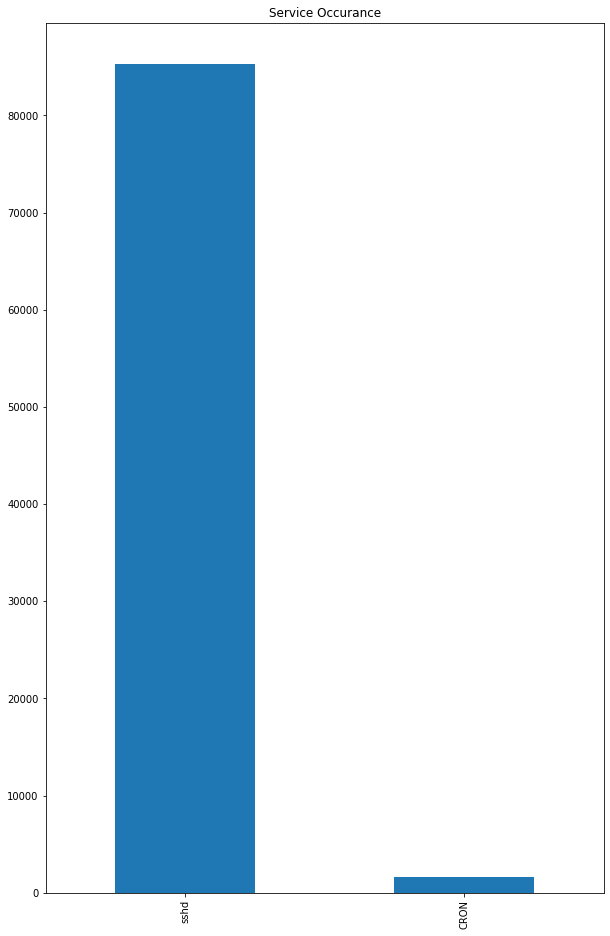

In [25]:
# Graph of the services used and how frequently (couldn't figure out how to get axis labels).
# only showed the first two bars when done in Google Colab. I haven't figured out where the extra came from in this one
df['Service'].value_counts().plot(kind='bar', title='Service Occurance', figsize=(10,16))  
plt.show()

In [26]:
# creates new dataframe of rows that contianed invalid user login attempts
df_invalid_user = df[df["Description"].str.contains(r'Invalid(?!$)')]

In [27]:
df_invalid_user.head()

,DateTime,IP,Service,Description,Connecting IP
10,Nov 30 08:42:04,172.31.27.153,sshd,Invalid user admin from 187.12.249.74,187.12.249.74
23,Nov 30 10:58:27,172.31.27.153,sshd,Invalid user admin from 122.225.109.208,122.225.109.208
342,Nov 30 15:22:39,172.31.27.153,sshd,Invalid user admin from 124.205.250.51,124.205.250.51
345,Nov 30 15:22:43,172.31.27.153,sshd,Invalid user guest from 124.205.250.51,124.205.250.51
348,Nov 30 15:22:48,172.31.27.153,sshd,Invalid user support from 124.205.250.51,124.205.250.51


In [28]:
# finds number of unique user login attempts and counts how many times each occurred
df_invalid_user_count = pd.DataFrame(df_invalid_user['Description'].value_counts().reset_index().values, columns=["Description", "Count"])


In [29]:
df_invalid_user_count

,Description,Count
0,Invalid user test from 188.87.35.25,96
1,Invalid user test from 67.205.20.23,86
2,Invalid user test from 78.129.223.28,86
3,Invalid user test from 220.99.93.50,82
4,Invalid user nagios from 188.87.35.25,65
...,...,...
3882,Invalid user admin from 5.21.228.5,1
3883,Invalid user bill from 87.106.240.120,1
3884,Invalid user support from 76.74.254.246,1
3885,Invalid user guest from 162.242.168.54,1


In [30]:
# converts Count column to integer
df_invalid_user_count['Count'].astype(int)

0       96
1       86
2       86
3       82
4       65
        ..
3882     1
3883     1
3884     1
3885     1
3886     1
Name: Count, Length: 3887, dtype: int64

In [31]:
# For sake of space, I only want unique logins with over 30 attempts
df_invalid_over_30 = df_invalid_user_count[(df_invalid_user_count['Count'] > 30)]
df_invalid_over_30

,Description,Count
0,Invalid user test from 188.87.35.25,96
1,Invalid user test from 67.205.20.23,86
2,Invalid user test from 78.129.223.28,86
3,Invalid user test from 220.99.93.50,82
4,Invalid user nagios from 188.87.35.25,65
5,Invalid user nagios from 220.99.93.50,65
6,Invalid user zabbix from 188.87.35.25,46
7,Invalid user guest from 220.99.93.50,45
8,Invalid user guest from 188.87.35.25,45
9,Invalid user admin from 222.161.209.92,40


In [32]:
# separates the IP from the description into its own column for clarity
df_invalid_over_30['IP'] = df_invalid_over_30["Description"].str.extract(r'(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})')
df_invalid_over_30

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Description,Count,IP
0,Invalid user test from 188.87.35.25,96,188.87.35.25
1,Invalid user test from 67.205.20.23,86,67.205.20.23
2,Invalid user test from 78.129.223.28,86,78.129.223.28
3,Invalid user test from 220.99.93.50,82,220.99.93.50
4,Invalid user nagios from 188.87.35.25,65,188.87.35.25
5,Invalid user nagios from 220.99.93.50,65,220.99.93.50
6,Invalid user zabbix from 188.87.35.25,46,188.87.35.25
7,Invalid user guest from 220.99.93.50,45,220.99.93.50
8,Invalid user guest from 188.87.35.25,45,188.87.35.25
9,Invalid user admin from 222.161.209.92,40,222.161.209.92


In [33]:
# Removes the invalud use part of the description leaving just the username and IP
df_invalid_over_30['Description'] = df_invalid_over_30['Description'].map(lambda x: str(x)[13:])
df_invalid_over_30

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Description,Count,IP
0,test from 188.87.35.25,96,188.87.35.25
1,test from 67.205.20.23,86,67.205.20.23
2,test from 78.129.223.28,86,78.129.223.28
3,test from 220.99.93.50,82,220.99.93.50
4,nagios from 188.87.35.25,65,188.87.35.25
5,nagios from 220.99.93.50,65,220.99.93.50
6,zabbix from 188.87.35.25,46,188.87.35.25
7,guest from 220.99.93.50,45,220.99.93.50
8,guest from 188.87.35.25,45,188.87.35.25
9,admin from 222.161.209.92,40,222.161.209.92


In [34]:
# removes the IP from the Description column leaving just hte username
df_invalid_over_30['Description'] = df_invalid_over_30['Description'].map(lambda x: str(x)[:-18])
df_invalid_over_30

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Description,Count,IP
0,test,96,188.87.35.25
1,test,86,67.205.20.23
2,test,86,78.129.223.28
3,test,82,220.99.93.50
4,nagios,65,188.87.35.25
5,nagios,65,220.99.93.50
6,zabbix,46,188.87.35.25
7,guest,45,220.99.93.50
8,guest,45,188.87.35.25
9,admin f,40,222.161.209.92


/opt/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


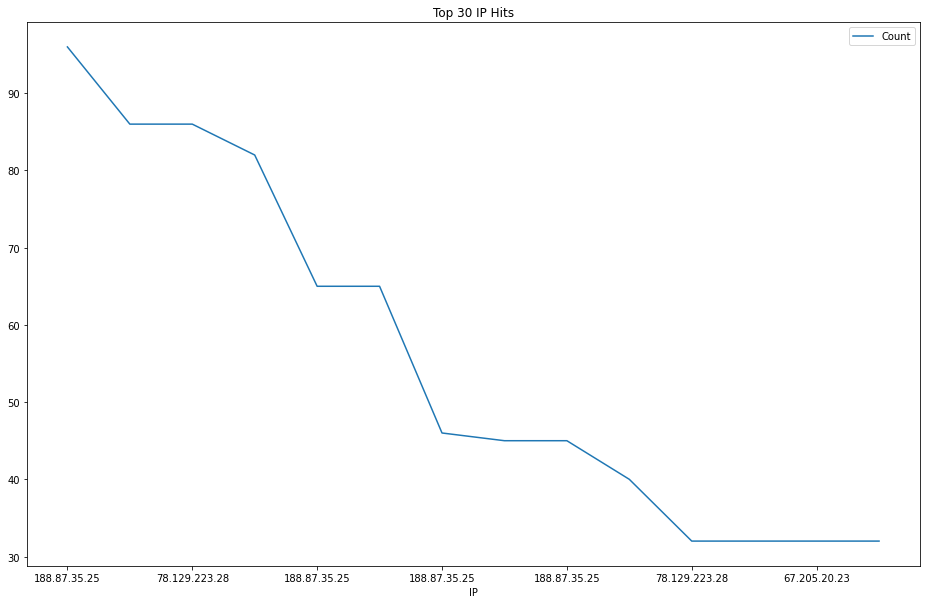

In [35]:
# shows the lnumber of login attempts for each IP with failed attempts over 30
df_invalid_over_30.plot(kind='line',x='IP',y='Count', title='Top 30 IP Hits', figsize=(16,10))
plt.show()

### Analyzing by month to see which has the most occurances.
    - Data was only collected from November and December

In [36]:
# Pulls any row containing the string "Nov" for November
df1 = df[df['DateTime'].str.contains("Nov")] 
df1

,DateTime,IP,Service,Description,Connecting IP
0,Nov 30 06:39:00,172.31.27.153,CRON,pam_unix(cron:session): session closed for use...,NaN
1,Nov 30 06:47:01,172.31.27.153,CRON,pam_unix(cron:session): session opened for use...,NaN
2,Nov 30 06:47:03,172.31.27.153,CRON,pam_unix(cron:session): session closed for use...,NaN
3,Nov 30 07:07:14,172.31.27.153,sshd,Connection closed by 122.225.103.87 [preauth],122.225.103.87
4,Nov 30 07:07:35,172.31.27.153,sshd,Connection closed by 122.225.103.87 [preauth],122.225.103.87
...,...,...,...,...,...
683,Nov 30 23:59:19,172.31.27.153,sshd,input_userauth_request: invalid user pi [preauth],NaN
684,Nov 30 23:59:19,172.31.27.153,sshd,Received disconnect from 221.208.245.210: 11: ...,221.208.245.210
685,Nov 30 23:59:21,172.31.27.153,sshd,Invalid user vyatta from 221.208.245.210,221.208.245.210
686,Nov 30 23:59:21,172.31.27.153,sshd,input_userauth_request: invalid user vyatta [p...,NaN


In [37]:
# creates new dataframe with just the string 'Nov'
df2= df1['DateTime'].str.extract(r'(Nov)')
df2

,0
0,Nov
1,Nov
2,Nov
3,Nov
4,Nov
...,...
683,Nov
684,Nov
685,Nov
686,Nov


In [38]:
# Pulls any row containing the string "Dec" for December
df3 = df[df['DateTime'].str.contains("Dec")] 
df3

,DateTime,IP,Service,Description,Connecting IP
688,Dec 1 00:17:01,172.31.27.153,CRON,pam_unix(cron:session): session opened for use...,NaN
689,Dec 1 00:17:01,172.31.27.153,CRON,pam_unix(cron:session): session closed for use...,NaN
690,Dec 1 00:33:49,172.31.27.153,sshd,Connection closed by 122.225.103.89 [preauth],122.225.103.89
691,Dec 1 00:34:17,172.31.27.153,sshd,Connection closed by 122.225.103.89 [preauth],122.225.103.89
692,Dec 1 00:35:04,172.31.27.153,sshd,Connection closed by 122.225.103.89 [preauth],122.225.103.89
...,...,...,...,...,...
86834,Dec 31 22:26:20,172.31.27.153,sshd,onnection closed by 218.2.0.133 [preauth],218.2.0.133
86835,Dec 31 22:27:07,172.31.27.153,sshd,onnection closed by 218.2.0.133 [preauth],218.2.0.133
86836,Dec 31 22:27:48,172.31.27.153,sshd,nvalid user admin from 218.2.0.133,218.2.0.133
86837,Dec 31 22:27:48,172.31.27.153,sshd,nput_userauth_request: invalid user admin [pre...,NaN


In [39]:
# creates new dataframe with just the string 'Dec'
df4= df3['DateTime'].str.extract(r'(Dec)')
df4

,0
688,Dec
689,Dec
690,Dec
691,Dec
692,Dec
...,...
86834,Dec
86835,Dec
86836,Dec
86837,Dec


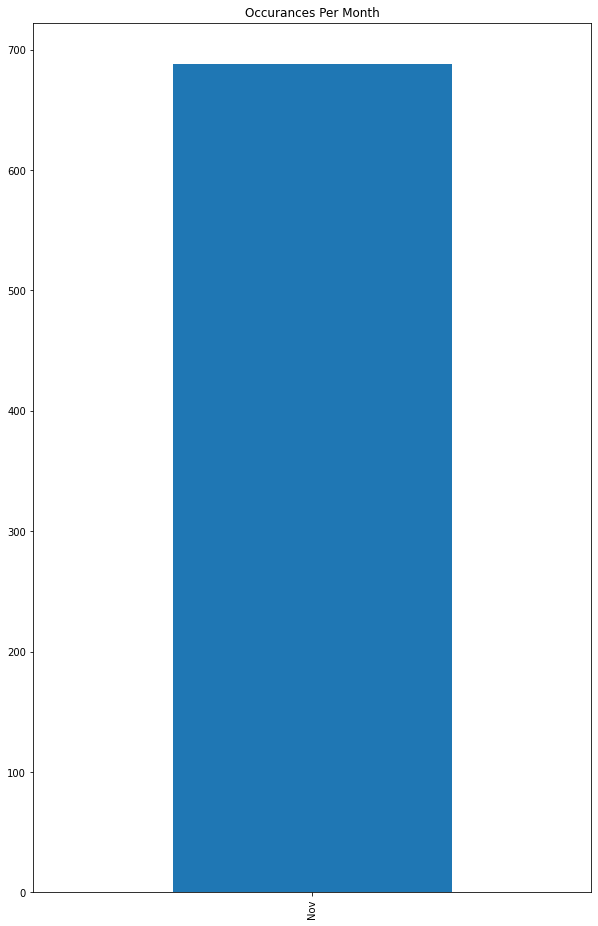

In [40]:
# Graph showing the occurances in november
df2[0].value_counts().plot(kind='bar', title='Occurances Per Month', figsize=(10,16))  
plt.show()

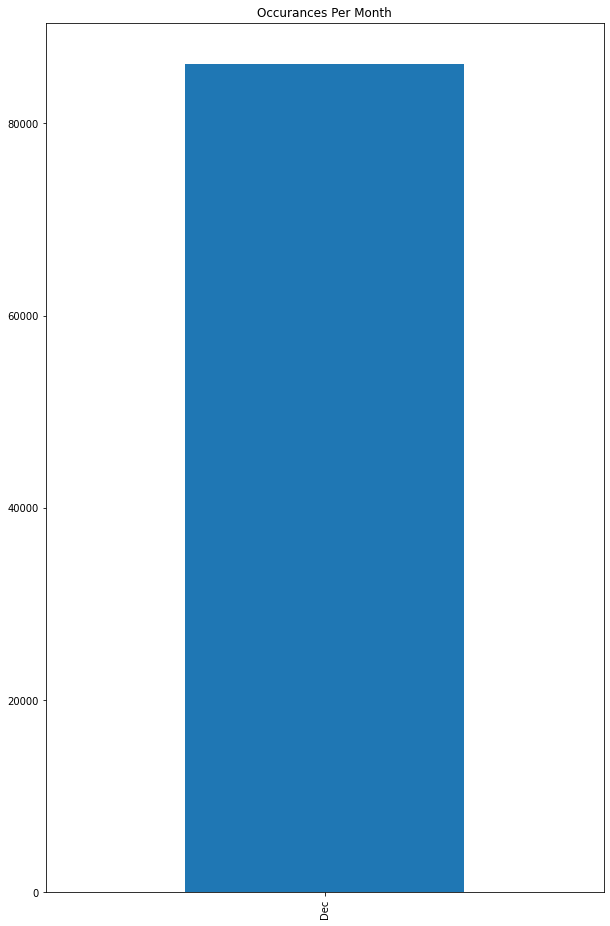

In [41]:
# graph showing the occurances in December 
df4[0].value_counts().plot(kind='bar', title='Occurances Per Month', figsize=(10,16))  
plt.show()

In [43]:
df5 = pd.concat([df2,df4], axis=1)
df5

,0,0
0,Nov,NaN
1,Nov,NaN
2,Nov,NaN
3,Nov,NaN
4,Nov,NaN
...,...,...
86834,NaN,Dec
86835,NaN,Dec
86836,NaN,Dec
86837,NaN,Dec


In [44]:
# general info about the dataframe
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86839 entries, 0 to 86838
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       688 non-null    object
 1   0       86151 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


### Focus on successful logins through Description column
- use pam_unix keyword

In [52]:
# Creates new dataframe with just the successful logins
df_session_open = df[df["Description"].str.contains(r'pam_unix\(cron:session\): session opened for user(?!$)')]
df_session_open


,DateTime,IP,Service,Description,Connecting IP
1,Nov 30 06:47:01,172.31.27.153,CRON,pam_unix(cron:session): session opened for use...,NaN
6,Nov 30 07:17:01,172.31.27.153,CRON,pam_unix(cron:session): session opened for use...,NaN
8,Nov 30 08:17:01,172.31.27.153,CRON,pam_unix(cron:session): session opened for use...,NaN
14,Nov 30 09:17:01,172.31.27.153,CRON,pam_unix(cron:session): session opened for use...,NaN
17,Nov 30 10:17:01,172.31.27.153,CRON,pam_unix(cron:session): session opened for use...,NaN
...,...,...,...,...,...
81181,Dec 28 20:17:01,172.31.27.153,CRON,pam_unix(cron:session): session opened for use...,NaN
81414,Dec 28 21:17:01,172.31.27.153,CRON,pam_unix(cron:session): session opened for use...,NaN
81545,Dec 28 22:17:01,172.31.27.153,CRON,pam_unix(cron:session): session opened for use...,NaN
81562,Dec 28 23:17:01,172.31.27.153,CRON,pam_unix(cron:session): session opened for use...,NaN


In [53]:
# basic info
df_session_open.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482 entries, 1 to 81587
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   DateTime       482 non-null    object
 1   IP             482 non-null    object
 2   Service        482 non-null    object
 3   Description    482 non-null    object
 4   Connecting IP  0 non-null      object
dtypes: object(5)
memory usage: 22.6+ KB


### Analyze detected breakin attempts
- use keyword 'reverse mapping'
- find unique occurances
- count the repeats from each IP
- narrow down to top 10 repeats and graph

In [55]:
# new dataframe for detected breakin attempts
df_breakin = df[df["Description"].str.contains(r'reverse mapping checking(?!$)')]
df_breakin

,DateTime,IP,Service,Description,Connecting IP
355,Nov 30 17:47:42,172.31.27.153,sshd,reverse mapping checking getaddrinfo for 118.1...,118.11.26.218
357,Nov 30 17:47:44,172.31.27.153,sshd,reverse mapping checking getaddrinfo for 118.1...,118.11.26.218
359,Nov 30 17:47:47,172.31.27.153,sshd,reverse mapping checking getaddrinfo for 118.1...,118.11.26.218
361,Nov 30 17:47:50,172.31.27.153,sshd,reverse mapping checking getaddrinfo for 118.1...,118.11.26.218
363,Nov 30 17:47:52,172.31.27.153,sshd,reverse mapping checking getaddrinfo for 118.1...,118.11.26.218
...,...,...,...,...,...
81052,Dec 28 19:48:21,172.31.27.153,sshd,reverse mapping checking getaddrinfo for 23.51...,23.51.128.49
81056,Dec 28 19:48:23,172.31.27.153,sshd,reverse mapping checking getaddrinfo for 23.51...,23.51.128.49
81060,Dec 28 19:48:25,172.31.27.153,sshd,reverse mapping checking getaddrinfo for 23.51...,23.51.128.49
81186,Dec 28 20:54:35,172.31.27.153,sshd,reverse mapping checking getaddrinfo for 118.1...,118.11.26.218


In [56]:
# Finds unique occurances of breakin attempts and counts the repeats
df_breakin_count = pd.DataFrame(df_breakin['Description'].value_counts().reset_index().values, columns=["Description", "Count"])

In [57]:
df_breakin_count

,Description,Count
0,reverse mapping checking getaddrinfo for stati...,1663
1,reverse mapping checking getaddrinfo for 92.20...,492
2,reverse mapping checking getaddrinfo for 177.4...,356
3,reverse mapping checking getaddrinfo for host-...,130
4,reverse mapping checking getaddrinfo for 118.1...,117
...,...,...
132,reverse mapping checking getaddrinfo for b-int...,1
133,reverse mapping checking getaddrinfo for ws.92...,1
134,reverse mapping checking getaddrinfo for 112.4...,1
135,reverse mapping checking getaddrinfo for r75-1...,1


In [68]:
# pull IP from description
df_breakin_count['IP'] = df_breakin_count["Description"].str.extract(r'(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})')
df_breakin_count

,Description,Count,IP
0,reverse mapping checking getaddrinfo for stati...,1663,NaN
1,reverse mapping checking getaddrinfo for 92.20...,492,92.209.161.222
2,reverse mapping checking getaddrinfo for 177.4...,356,177.43.213.35
3,reverse mapping checking getaddrinfo for host-...,130,NaN
4,reverse mapping checking getaddrinfo for 118.1...,117,118.11.26.218
...,...,...,...
132,reverse mapping checking getaddrinfo for b-int...,1,95.191.255.22
133,reverse mapping checking getaddrinfo for ws.92...,1,92.127.229.59
134,reverse mapping checking getaddrinfo for 112.4...,1,112.49.174.61
135,reverse mapping checking getaddrinfo for r75-1...,1,NaN


In [70]:
# drops null values
df_breakin_count = df_breakin_count.dropna()
df_breakin_count

,Description,Count,IP
1,reverse mapping checking getaddrinfo for 92.20...,492,92.209.161.222
2,reverse mapping checking getaddrinfo for 177.4...,356,177.43.213.35
4,reverse mapping checking getaddrinfo for 118.1...,117,118.11.26.218
12,reverse mapping checking getaddrinfo for 23.51...,51,23.51.128.49
23,reverse mapping checking getaddrinfo for . [68...,19,68.65.210.102
...,...,...,...
129,reverse mapping checking getaddrinfo for b-int...,1,95.191.254.226
132,reverse mapping checking getaddrinfo for b-int...,1,95.191.255.22
133,reverse mapping checking getaddrinfo for ws.92...,1,92.127.229.59
134,reverse mapping checking getaddrinfo for 112.4...,1,112.49.174.61


In [73]:
# limits to those IPs that attempted to break in > 10 times
df_breakin_over_10 = df_breakin_count[(df_invalid_user_count['Count'] > 10)]
df_breakin_over_10

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Description,Count,IP
1,reverse mapping checking getaddrinfo for 92.20...,492,92.209.161.222
2,reverse mapping checking getaddrinfo for 177.4...,356,177.43.213.35
4,reverse mapping checking getaddrinfo for 118.1...,117,118.11.26.218
12,reverse mapping checking getaddrinfo for 23.51...,51,23.51.128.49
23,reverse mapping checking getaddrinfo for . [68...,19,68.65.210.102
25,reverse mapping checking getaddrinfo for 251.5...,15,251.50.174.61
27,reverse mapping checking getaddrinfo for 169.7...,9,169.78.120.106
28,reverse mapping checking getaddrinfo for 204.5...,9,204.51.174.61
29,reverse mapping checking getaddrinfo for 208.5...,9,208.50.174.61
30,reverse mapping checking getaddrinfo for 161.5...,9,161.50.174.61


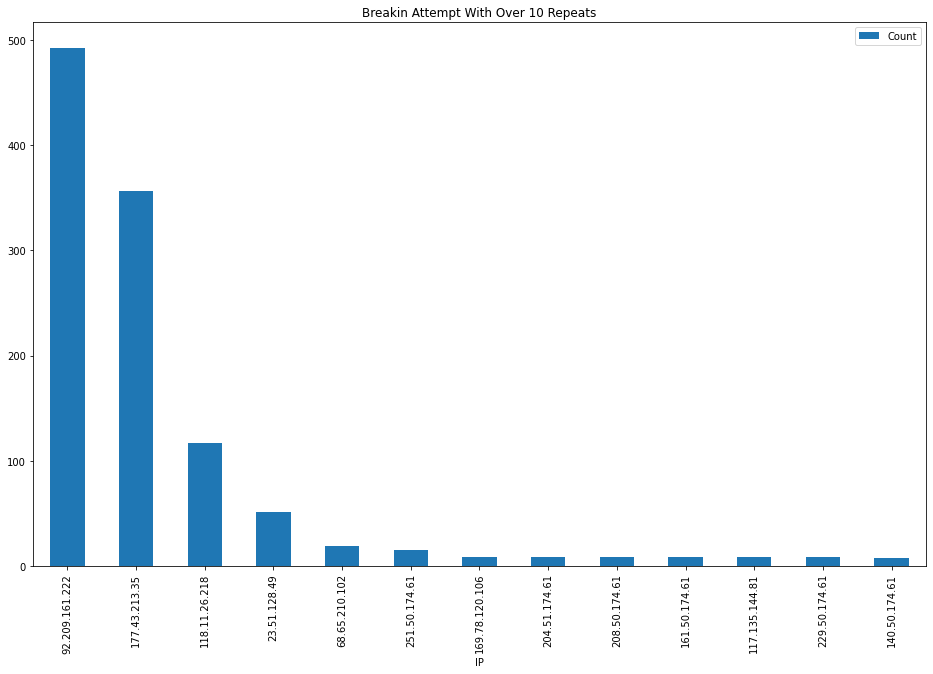

In [75]:
# bar graph of breakin attempts > 10
df_breakin_over_10.plot(kind='bar',x='IP',y='Count', title='Breakin Attempt With Over 10 Repeats', figsize=(16,10))
plt.show()

# Conclusion

### Questions Answered
#### What IPs try to authenticate?
    - I focused on the authentication attempts that failed, since those are the ones most likely to be malicious. 
    - There were 1906 unique IPs that attemted to authenticate to the 172.31.27.153 device. There were 3887 failed authentications
#### What services are used to authenticate?
    - CRON and SSHD were the two services used to authenticate. 
#### What IP has the most failed login attempts?
    - 61.197.203.243 had the most login attempts with 11261
    - The IP 188.87.35.25 had the most failed logins with 96 using the username test
#### What type authentication is the one that fails the most?
    - SSHD (secure remote) authentication failed the most frequently 
    - Most failed attempts were due to invalid usernames
#### What IP is trying to be authenticated to?
    - The device being authenticated to is 172.31.27.153
#### Are there any failed/successful remote logins?
    - There were 3887 failed login attempts. 
    - 482 successful logins (user root)
    - 4058 detected breakin attempts - 137 unique attempts
        - 92.209.161.222 had the most attempts at 492
#### Were there any privelege escalation attempts?
    - No. There was no evidence of the sudo command being run in the logs. 
#### What time frame is covered?
    - All data was collected over two months: November and December. 
    - 688 entries were from November and the remaining 86151 were from December

### Final Thoughts
- Data would have been more interesting if collected over a longer period of time on a more active device
- This auth.log seems to be missing a lot of data found in most auth.logs. Probably an older version of Linux
- This device is not typically accessed via remote login. The number of successful logins is too small
- The unsuccessful logins are numerous, mostly because of invalid users. It is not clear why this is. 
- Logs providing non-authentication type data would give greater insight into what this device is used for
- What causes the logs to identify potential breakin attempts is unclear. More research is needed. 